## Section 0: Install packages

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
! pip install uproot
! conda install -c conda-forge xrootd

Solving environment: \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.7.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.7.2



# All requested packages already installed.



Section 1: Data Formats and Exploration
===============================================================

Particle physics uses a data format (and analysis ecosystem) based on the `ROOT` library: https://root.cern.ch/.
`ROOT` is a framework for data processing, born at CERN, at the heart of the research on high-energy physics.
A `ROOT` file is a compressed binary file in which we can save objects of any type.
There are python bindings built into `ROOT`, so called `PyROOT`, but for now we won't discuss this.

Recently, a different library called `uproot` has been developed allowing python users to do `ROOT` I/O directly: https://uproot.readthedocs.io/en/latest/.
`uproot` is a reader and a writer of the `ROOT` file format using only `Python` and `Numpy`.
Unlike the standard C++ `ROOT` implementation, uproot is only an I/O library, primarily intended to stream data into machine learning libraries in `Python`.
Unlike `PyROOT` and `root_numpy`, uproot does not depend on C++ `ROOT`.
Instead, it uses `Numpy` to cast blocks of data from the `ROOT` file as `Numpy` arrays.
It can also make jagged or awkward arrays based on this library: https://github.com/scikit-hep/awkward-1.0 {cite:p}`Pivarski:2020qcb`.


For a tutorial on `uproot`, see: https://hsf-training.github.io/hsf-training-uproot-webpage/ or here: https://github.com/jpivarski-talks/2020-07-13-pyhep2020-tutorial.

In [ ]:
import uproot

## Remote files
One nice feature of `ROOT` and `uproot` is the ability to read a file remotely.
This is done using the `XRootD` library: https://xrootd.slac.stanford.edu/.
`XRootD` is a generic suite for fast, low latency and scalable data access, which can serve natively any kind of data, organized as a hierarchical filesystem-like namespace, based on the concept of directory.

## XRootD filenames
We specify that this is a remote file accessed via `XRootD` using the `root://` protocol in front of the filename.
The redirector `eospublic.cern.ch` specifies that we're accessing data from the CERN open data repository.
And finally the rest of the file name `/eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root` specifies the exact file.

In [ ]:
f = uproot.open('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root')

## Trees
One common object is a tree.
Trees in `ROOT` are basically just tables of information.
Trees are composed of branches, which are the columns of the table.
The rows usually represent events (individual bunch crossings).
However, in this case, each row represents a jet (a localized collection of particles within a single event).

First we assign the tree to a variable (named `tree` here).
We can see how many rows (jets) are contained in the tree, by checking its `num_entries`.

In [ ]:
tree = f['deepntuplizer/tree']
print(tree.num_entries)

200000


Let's list the contents (branches) of the tree.

In [ ]:
tree.show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
Delta_gen_pt         | float                    | AsDtype('>f4')
event_no             | uint32_t                 | AsDtype('>u4')
gen_pt               | float                    | AsDtype('>f4')
isB                  | int32_t                  | AsDtype('>i4')
isBB                 | int32_t                  | AsDtype('>i4')
isC                  | int32_t                  | AsDtype('>i4')
isG                  | int32_t                  | AsDtype('>i4')
isLeptonicB          | int32_t                  | AsDtype('>i4')
isLeptonicB_C        | int32_t                  | AsDtype('>i4')
isS                  | int32_t                  | AsDtype('>i4')
isUD                 | int32_t                  | AsDtype('>i4')
isUndefined          | int32_t                  | AsDtype('>i4')
jet_corr_pt          | float                    | AsDtype(

## A note on "jaggedness"

Some branches are listed has having an interpretation of `asdtype('>f4')` while some others are listed as `asjagged(asdtype('>f4'), 10)`.
The former means there is only one number per jet.
The latter means there may a variable number per jet.

First, let's get just look at non-jagged arrays, starting with the ground truth labels.

In [ ]:
# Returns a dictionary
labels = tree.arrays(['label_QCD_b',
                      'label_QCD_bb',
                      'label_QCD_c',
                      'label_QCD_cc',
                      'label_QCD_others',
                      'label_H_bb',
                      'sample_isQCD'],
                     entry_stop=20000,
                     library='np')
labels

{'label_QCD_b': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_c': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'label_QCD_cc': array([0, 0, 0, ..., 0, 1, 1], dtype=int32),
 'label_QCD_others': array([1, 1, 1, ..., 1, 0, 0], dtype=int32),
 'label_H_bb': array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 'sample_isQCD': array([1, 1, 1, ..., 1, 1, 1], dtype=int32)}

In [ ]:
# label QCD: require the sample to be QCD and any of the QCD flavors
label_QCD = labels['sample_isQCD'] * (labels['label_QCD_b'] + \
                                      labels['label_QCD_bb'] + \
                                      labels['label_QCD_c'] + \
                                      labels['label_QCD_cc'] + \
                                      labels['label_QCD_others'])

# label Hbb
label_Hbb = labels['label_H_bb']

## What is the signal and background?

Signal (Higgs) events for this task look like this:

$$gg \to X\to HH \to b\bar{b}b\bar{b}$$

<img width = 400px src="http://cms-results.web.cern.ch/cms-results/public-results/publications/B2G-17-006/CMS-B2G-17-006_Figure_001-a.png"/>

Background (QCD) events for this task look like this:

$$gg \to q \bar{q} / gg / b\bar{b} / gb\bar{b} / ggg / \cdots$$

<img width = 400px src="https://www.physik.uzh.ch/~che/FeynDiag/diagrams/1_pp_scattering/10000013.png"/>

We will look at differentiating signal and background at the "jet" level.

In [ ]:
# number of overlap jets
sum(label_QCD*label_Hbb)

0

In [ ]:
# fraction of jets with some truth label defined
sum(label_QCD+label_Hbb)/len(label_QCD+label_Hbb)

0.93785

In [ ]:
# jet features, namely transverse momemntum (pt) and soft-drop mass  (sdmass or msd)
jet_features = tree.arrays(['fj_pt',
                            'fj_sdmass'],
                          entry_stop=20000,
                          library='np')

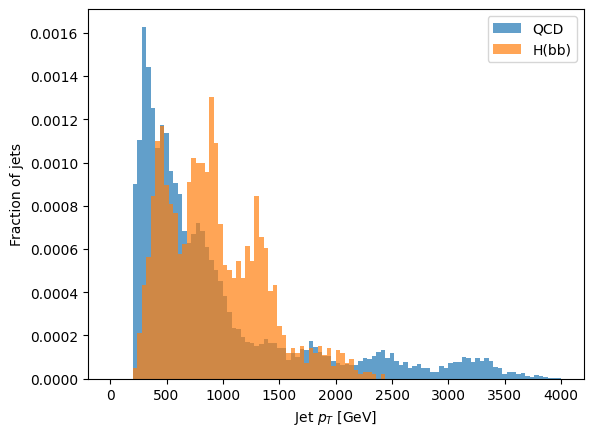

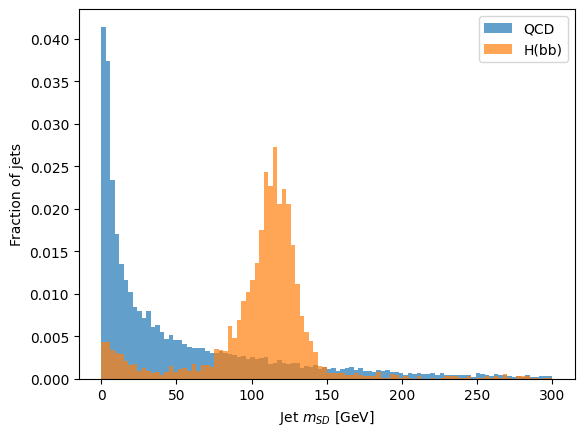

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

plt.hist(jet_features['fj_pt'],weights=label_QCD,bins=np.linspace(0,4000,101),density=True,alpha=0.7,label='QCD')
plt.hist(jet_features['fj_pt'],weights=label_Hbb,bins=np.linspace(0,4000,101),density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Jet $p_{T}$ [GeV]')
plt.ylabel('Fraction of jets')
plt.legend()

plt.figure()

plt.hist(jet_features['fj_sdmass'],weights=label_QCD,bins=np.linspace(0,300,101),density=True,alpha=0.7,label='QCD')
plt.hist(jet_features['fj_sdmass'],weights=label_Hbb,bins=np.linspace(0,300,101),density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Jet $m_{SD}$ [GeV]')
plt.ylabel('Fraction of jets')
plt.legend()

plt.show()

## Jagged arrys

Now let's look at an jagged (or awkward) array, like those related to track features, where there can be a variable number of tracks per jet.

In [ ]:
import awkward as ak
track_features = tree.arrays(['track_pt',
                              'label_H_bb'],
                             entry_stop=20000,
                             library='ak')
track_features

<Array [{track_pt: [...], ...}, ..., {...}] type='20000 * {track_pt: var * ...'>

Note the difference between a "flat" array, where these a fixed number per jet (like 1 per jet in the case of jet properties) and a jagged array, where there are a variable number.

We can demonstrate this by looking at the first jet in the dataset. As we'll see there are 21 tracks, each with their own pt.

In [ ]:
jet_features['fj_pt'][0]

251.27692

In [ ]:
track_features['track_pt'][0]

<Array [1.05, 0.957, 1.46, 1.09, ..., 18.2, 1.62, 1.23] type='21 * float32'>

Note, behind the scenes, jagged arrays are just like normal numpy arrays, except there's additional structure, retreivable from the `ak.num` function, which tells us the (variable) number of tracks per jet.

In [ ]:
ak.num(track_features['track_pt'])

<Array [21, 35, 24, 32, 28, 24, ..., 19, 16, 25, 20, 45] type='20000 * int64'>

## Operations with jaggedness

We can plot the full distibution of track pts. But what if we want to find the highest track pt per jet and plot only that?

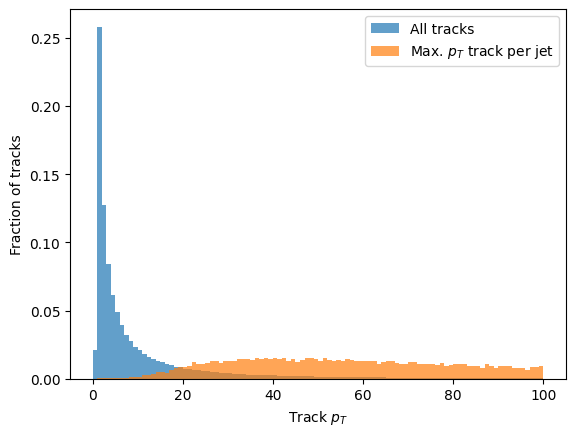

In [ ]:
plt.figure()
plt.hist(ak.flatten(track_features['track_pt']),bins=np.linspace(0,100,101),density=True,alpha=0.7,label='All tracks')
plt.hist(ak.max(track_features['track_pt'], axis=-1),bins=np.linspace(0,100,101),density=True,alpha=0.7,label=r'Max. $p_{T}$ track per jet')

plt.xlabel(r'Track $p_{T}$')
plt.ylabel('Fraction of tracks')
plt.legend()
plt.show()

## Conversion to regular array

Sometimes we want to turn a jagged array into a regular array to make it easier to accomodate into a machine learning algorithm (like a fully conneted or convolutional neural network).
The simplest way to do this is to use zero-padding and truncation to "cap" the number of objects at some fixed value, and zero-pad if there are less objects.

To do this, we can first plot how many tracks there are per jet and choose a reasonable number to cap.

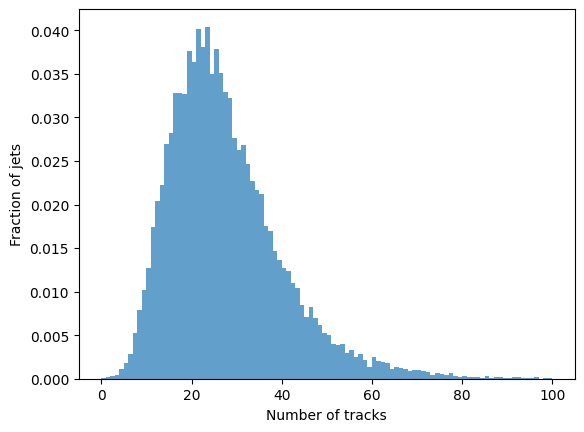

In [ ]:
plt.figure()
plt.hist(ak.num(track_features['track_pt']),bins=np.linspace(0,100,101),density=True,alpha=0.7)

plt.xlabel(r'Number of tracks')
plt.ylabel('Fraction of jets')
plt.show()

In this case, 60 seems to be a reasonable number.

In [ ]:
max_tracks = 60
pad_value = 0
a = ak.fill_none(ak.pad_none(track_features['track_pt'], max_tracks, clip=True, axis=-1), pad_value, axis=-1).to_numpy()
print(a.shape)
a

(20000, 60)


array([[ 1.05371094,  0.95654297,  1.45703125, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.78320312,  3.52539062, 49.09375   , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.53027344,  6.81640625,  2.92578125, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.08105469,  2.5234375 , 10.265625  , ...,  0.        ,
         0.        ,  0.        ],
       [ 4.8125    ,  2.6796875 ,  3.98242188, ...,  0.        ,
         0.        ,  0.        ],
       [ 2.41015625,  1.43457031,  2.46289062, ...,  0.        ,
         0.        ,  0.        ]])

To recreate the previous plot, we can do the following (note: we expect minor differences):

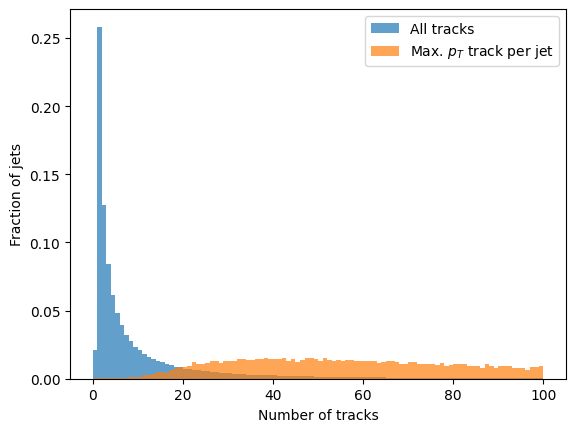

(array([    0,     0,     0, ..., 19999, 19999, 19999]), array([ 0,  1,  2, ..., 42, 43, 44]))


In [ ]:
plt.figure()
plt.hist(a[a>0],bins=np.linspace(0,100,101),density=True,alpha=0.7, label='All tracks')
plt.hist(np.max(a,axis=-1),bins=np.linspace(0,100,101),density=True,alpha=0.7, label=r'Max. $p_{T}$ track per jet')

plt.xlabel(r'Number of tracks')
plt.ylabel('Fraction of jets')
plt.legend()
plt.show()
print(a.nonzero())

Section 2: Feature Engineering
===============================================================

Many different kinds of features have been specially engineered to perform b-tagging. We will consider several of these today.

## b hadrons

B hadrons contain bottom quarks.
These hadrons are unstable, meaning they naturally (and spontaneously) decay to hadrons containing lighter quarks, after a period of time (with a known median lifetime).

Because of the large mass difference between bottom quarks and the lighter quarks, the lifetime of b hadrons tends to be relatively long: around $10^{-12}$ s.
Given the fact that they are traveling near the speed of light, this means they can travel $O$(mm) in the detector before dacaying.
The particle sproduced from this decay also tend to be higher energy

Therefore, we can consider the properties of *displaced tracks* and *secondary vertices* (points of origin of collections of displaced tracks).
In particular we quantify how displaced a track is in terms of its *impact parameter*.

## Single b-tagging

For single b-tagging, consider the following image:
<img src="http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/CMS-BTV-16-002_Figure_001.png" alt="b-tagging" width="500">

For more information, read {cite:p}`Sirunyan:2017ezt`.

## Double b-tagging

For double b-tagging, consider the following image:
<img src="https://github.com/jmduarte/capstone-particle-physics-domain/raw/master/weeks/Hbb.png" alt="double b-tagging" width="500">

For this, we can also take advantage of the so-called *jet substructure*. For more information, read {cite:p}`Marzani:2019hun,Asquith:2018igt`.


In [ ]:
import uproot
f = uproot.open('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root')

In [ ]:
tree = f['deepntuplizer/tree']

In [ ]:
labels = tree.arrays(['label_QCD_b',
                      'label_QCD_bb',
                      'label_QCD_c',
                      'label_QCD_cc',
                      'label_QCD_others',
                      'label_H_bb',
                      'sample_isQCD'],
                     entry_stop=20000,
                     library='np')

In [ ]:
# label QCD: require the sample to be QCD and any of the QCD flavors
label_QCD = labels['sample_isQCD'] * (labels['label_QCD_b'] + \
                                      labels['label_QCD_bb'] + \
                                      labels['label_QCD_c'] + \
                                      labels['label_QCD_cc'] + \
                                      labels['label_QCD_others'])

# label Hbb
label_Hbb = labels['label_H_bb']

Let's load a sampling of track, secondary vertex, and jet features.

In [ ]:
track_features = tree.arrays(['track_pt',
                              'track_dxy',
                              'track_dxysig',
                              'track_dz',
                              'track_dzsig',
                              'trackBTag_Sip2dSig',
                              'trackBTag_Sip2dVal',
                              'trackBTag_Sip3dSig',
                              'trackBTag_Sip3dVal',
                              'trackBTag_PtRatio',
                              'trackBTag_PParRatio'],
                             entry_stop=20000,
                             library='ak')

In [ ]:
sv_features = tree.arrays(['sv_pt',
                           'sv_mass'],
                          entry_stop=20000,
                          library='ak')

In [ ]:
jet_features = tree.arrays(['fj_pt',
                            'fj_sdmass',
                            'fj_mass',
                            'fj_tau21',
                            'fj_jetNTracks',
                            'fj_trackSipdSig_0',
                            'fj_trackSipdSig_1'],
                           entry_stop=20000,
                           library='np')

## Visualize Separation of Track Features

Let's visualize the separation by plotting the signal and background for several track features that may be important.
- Number of tracks
- Maximum relative track $p_T$
- Maximum signed 3D impact parameter value
- Maximum signed 3D impact parameter significance: this is the value above divded by the estimated uncertainty of the measurement. This enables us to tell how "significant" (far from impact parameter of 0), this value is.

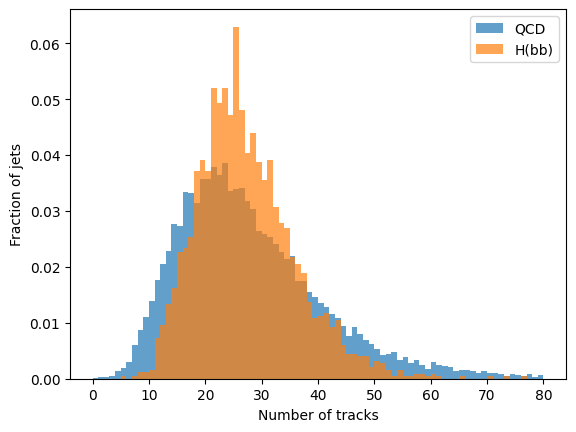

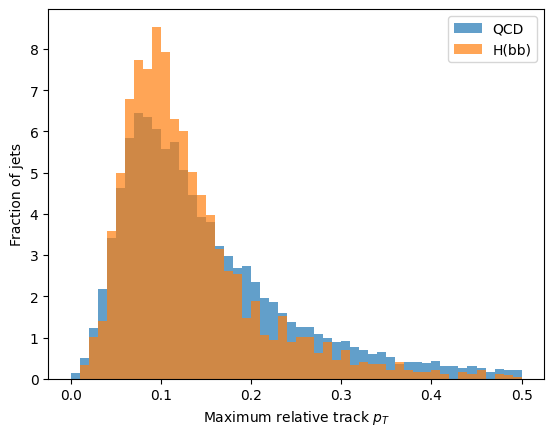

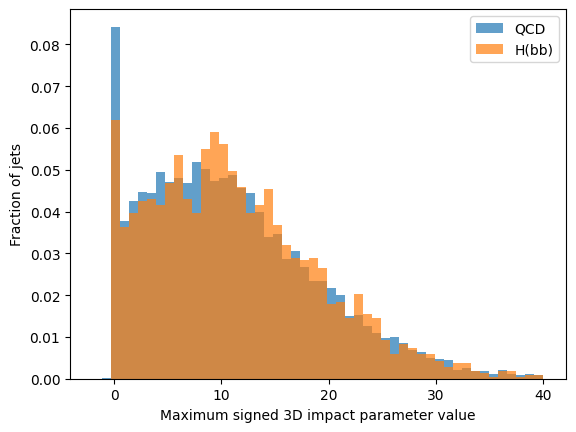

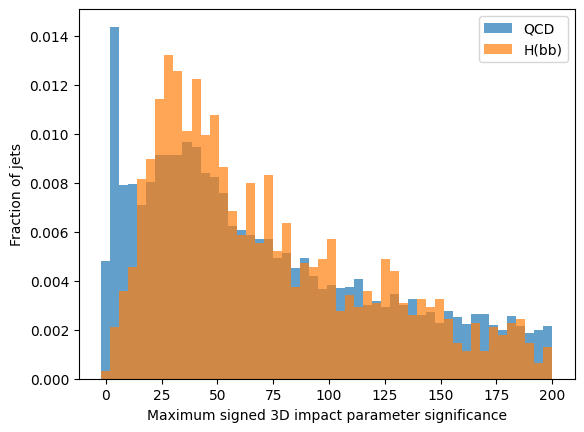

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak

# number of tracks
plt.figure()
plt.hist(ak.num(track_features['track_pt']), weights=label_QCD, bins=np.linspace(0,80,81), density=True, alpha=0.7, label='QCD')
plt.hist(ak.num(track_features['track_pt']), weights=label_Hbb, bins=np.linspace(0,80,81), density=True, alpha=0.7, label='H(bb)')
plt.xlabel('Number of tracks')
plt.ylabel('Fraction of jets')
plt.legend()

# max. relative track pt
plt.figure()
plt.hist(ak.max(track_features['track_pt'], axis=-1)/jet_features['fj_pt'], weights=label_QCD, bins=np.linspace(0,0.5,51), density=True,alpha=0.7,label='QCD')
plt.hist(ak.max(track_features['track_pt'], axis=-1)/jet_features['fj_pt'], weights=label_Hbb, bins=np.linspace(0,0.5,51), density=True,alpha=0.7,label='H(bb)')
plt.xlabel(r'Maximum relative track $p_{T}$')
plt.ylabel('Fraction of jets')
plt.legend()

# maximum signed 3D impact paramter value
plt.figure()
plt.hist(ak.max(track_features['trackBTag_Sip3dVal'], axis=-1), weights=label_QCD, bins=np.linspace(-2,40,51), density=True, alpha=0.7, label='QCD')
plt.hist(ak.max(track_features['trackBTag_Sip3dVal'], axis=-1), weights=label_Hbb, bins=np.linspace(-2,40,51), density=True, alpha=0.7, label='H(bb)')
plt.xlabel('Maximum signed 3D impact parameter value')
plt.ylabel('Fraction of jets')
plt.legend()

# maximum signed 3D impact paramter significance
plt.figure()
plt.hist(ak.max(track_features['trackBTag_Sip3dSig'], axis=-1), weights=label_QCD, bins=np.linspace(-2,200,51), density=True, alpha=0.7, label='QCD')
plt.hist(ak.max(track_features['trackBTag_Sip3dSig'], axis=-1), weights=label_Hbb, bins=np.linspace(-2,200,51), density=True, alpha=0.7, label='H(bb)')
plt.xlabel('Maximum signed 3D impact parameter significance')
plt.ylabel('Fraction of jets')
plt.legend()

plt.show()

## Visualize Separation of SV Features

Let's visualize the separation by plotting the signal and background for several track features that may be important.
- Number of secondary vertices
- Maximum relative secondary vertex $p_T$
- Maximum relative secondary vertex mass

## ROC Curves
ROC curves can tell us how well each of these features discriminates betweeen signal and background.

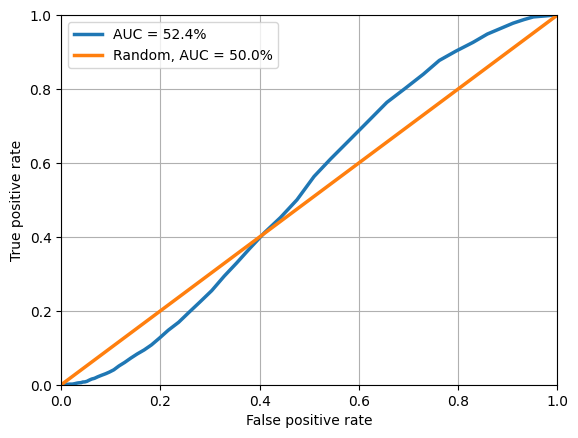

In [ ]:
from sklearn.metrics import roc_curve, auc
disc = np.nan_to_num(ak.num(track_features['track_pt'], axis=-1).to_numpy(allow_missing=True))

fpr, tpr, threshold = roc_curve(label_Hbb, disc)
# plot ROC curve
plt.figure()
plt.plot(fpr, tpr, lw=2.5, label="AUC = {:.1f}%".format(auc(fpr,tpr)*100))
plt.xlabel(r'False positive rate')
plt.ylabel(r'True positive rate')
#plt.semilogy()
plt.ylim(0,1)
plt.xlim(0,1)
plt.plot([0, 1], [0, 1], lw=2.5, label='Random, AUC = 50.0%')
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

## Other engineered features
To read more about the features read this: http://opendata.cern.ch/record/12102

Here is a selection:


| Data variable | Type | Description |
| :---------------------- | -----------------: | :---------------------- |
| `event_no` | UInt_t | Event number |
| `npv` | Float_t | Number of reconstructed primary vertices (PVs) |
| `ntrueInt` | Float_t | True mean number of the poisson distribution for this event from which the number of interactions in each bunch crossing has been sampled |
| `rho` | Float_t | Median density (in GeV/A) of pile-up contamination per event; computed from all PF candidates of the event |
| `sample_isQCD` | Int_t | Boolean that is 1 if the simulated sample corresponds to QCD multijet production |
| `label_H_bb` | Int_t | Boolean that is 1 if a Higgs boson is matched and at least two b quarks are found within the AK8 jet |
| `label_QCD_bb` | Int_t | Boolean that is 1 if no resonances are matched and at least two b quarks are found within the AK8 jet |
| `label_QCD_b` | Int_t | Boolean that is 1 if no resonances are matched and only one b quark is found within the AK8 jet |
| `label_QCD_cc` | Int_t | Boolean that is 1 if no resonances are matched and at least two c quarks are found within the AK8 jet |
| `label_QCD_c` | Int_t | Boolean that is 1 if no resonances are matched and only one c quark is found within the AK8 jet |
| `label_QCD_others` | Int_t | Boolean that is 1 if no resonances are matched and no b or c quarks are found within the AK8 jet |
| `fj_doubleb` | Float_t | Double-b tagging discriminant based on a boosted decision tree calculated for the AK8 jet (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/)) |
| `fj_eta` | Float_t | Pseudorapidity η of the AK8 jet |
| `fj_gen_eta` | Float_t | Pseudorapidity η of the generator-level, matched heavy particle: H, W, Z, top, etc. (default = -999) |
| `fj_gen_pt` | Float_t | Transverse momentum of the generator-level, geometrically matched heavy particle: H, W, Z, t, etc. (default = -999)  |
| `fj_isBB` | Int_t | Boolean that is 1 if two or more b hadrons are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_isNonBB` | Int_t | Boolean that is 1 if fewer than two b hadrons are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_nbHadrons` | Int_t | Number of b hadrons that are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_ncHadrons` | Int_t | Number of c hadrons that are clustered within the AK8 jet (see [SWGuideBTagMCTools](https://twiki.cern.ch/twiki/bin/view/CMSPublic/SWGuideBTagMCTools)) |
| `fj_isH` | Int_t | Boolean that is 1 if a generator-level Higgs boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isTop` | Int_t | Boolean that is 1 if a generator-level top quark and its daughters are geometrically matched to the AK8 jet |
| `fj_isW` | Int_t | Boolean that is 1 if a generator-level W boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isZ` | Int_t | Boolean that is 1 if a generator-level Z boson and its daughters are geometrically matched to the AK8 jet |
| `fj_isQCD` | Int_t | Boolean that is 1 if none of the above matching criteria are satisfied (H, top, W, Z) |
| `fj_label` | Int_t | Integer label: `Invalid=0,  Top_all=10, Top_bcq=11, Top_bqq=12, Top_bc=13, Top_bq=14, W_all=20, W_cq=21, W_qq=22, Z_all=30, Z_bb=31, Z_cc=32, Z_qq=33, H_all=40, H_bb=41, H_cc=42, H_qqqq=43, QCD_all=50, QCD_bb=51, QCD_cc=52, QCD_b=53, QCD_c=54, QCD_others=55` |
| `fj_labelJMAR` | Int_t | Alternative integer label from the CMS Jet/MET and Resolution (JMAR) group:  `Default=0, Top=1, W=2, Z=3, H=4` |
| `fj_labelLegacy` | Int_t | Alternative (legacy) integer label: `Default=0, Top=1, W=2, Z=3, H=4` |
| `fj_jetNTracks` | Float_t | Number of tracks associated with the AK8 jet |
| `fj_nSV` | Float_t | Number of SVs associated with the AK8 jet (∆R < 0.7) |
| `fj_n_sdsubjets` | Float_t | Number of soft drop subjets in the AK8 jet (up to 2) |
| `fj_mass` | Float_t | Ungroomed mass of the AK8 jet |
| `fj_phi` | Float_t | Azimuthal angle ϕ of the AK8 jet |
| `fj_pt` | Float_t | Transverse momentum of the AK8 jet |
| `fj_tau1` | Float_t | N-subjettiness variable for a 1-prong jet hypothesis |
| `fj_tau2` | Float_t | N-subjettiness variable for a 2-prong jet hypothesis |
| `fj_tau3` | Float_t | N-subjettiness variable for a 3-prong jet hypothesis |
| `fj_tau21` | Float_t | N-subjettiness variable for 2-prong vs 1-prong jet discrimination (`fj_tau2/fj_tau1`) |
| `fj_tau32` | Float_t | N-subjettiness variable for 3-prong vs 2-prong jet discrimination (`fj_tau3/fj_tau2`) |
| `fj_sdmass` | Float_t | Soft drop mass of the AK8 jet |
| `fj_ptDR` | Float_t | Transverse momentum times the ΔR between the two soft drop subjets |
| `fj_relptdiff` | Float_t | Absolute relative difference between the transverse momenta of the two softdrop subjets |
| `fj_sdn2` | Float_t | Fraction of second subjet transverse momentum times ∆R squared |
| `fj_sdsj1_axis1` | Float_t | First axis of the first subjet |
| `fj_sdsj1_axis2` | Float_t | Second axis of the first subjet |
| `fj_sdsj1_csv` | Float_t | Combined secondary vertex (CSV) b-tagging discriminant for the first subjet |
| `fj_sdsj1_eta` | Float_t | Pseudorapidity η of the first subjet |
| `fj_sdsj1_mass` | Float_t | Mass of the first subjet |
| `fj_sdsj1_mult` | Float_t | Particle multiplicity of the first subjet |
| `fj_sdsj1_phi` | Float_t | Azimuthal angle ϕ of the first subjet |
| `fj_sdsj1_pt` | Float_t | Transverse momentum of the first subjet |
| `fj_sdsj1_ptD` | Float_t | ptD variable, defined as the square root of the sum in quadrature of the transverse momentum of the subjet constituents divided by the scalar sum of the transverse momentum of the subjet constituents, for the first subjet (see [CMS-PAS-JME-13-002](https://cds.cern.ch/record/1599732)) |
| `fj_sdsj2_axis1` | Float_t | First axis of the first subjet |
| `fj_sdsj2_axis2` | Float_t | Second axis of the first subjet |
| `fj_sdsj2_csv` | Float_t | Combined secondary vertex (CSV) b-tagging discriminant for the first subject |
| `fj_sdsj2_eta` | Float_t | Pseudorapidity η of the second subjet |
| `fj_sdsj2_mass` | Float_t | Mass of the second subjet |
| `fj_sdsj2_mult` | Float_t | Particle multiplicity of the second subjet |
| `fj_sdsj2_phi` | Float_t | Azimuthal angle ϕ of the second subjet |
| `fj_sdsj2_pt` | Float_t | Transverse momentum of the second subjet |
| `fj_sdsj2_ptD` | Float_t | ptD variable, defined as the square root of the sum in quadrature of the transverse momentum of the subjet constituents divided by the scalar sum of the transverse momentum of the subjet constituents, for the second subjet (see [CMS-PAS-JME-13-002](https://cds.cern.ch/record/1599732)) |
| `fj_z_ratio` | Float_t | z ratio variable as defined in [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) |
| `fj_trackSipdSig_0` | Float_t | First largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) ) |
| `fj_trackSipdSig_1` | Float_t | Second largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) ) |
| `fj_trackSipdSig_2` | Float_t | Third largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) )  |
| `fj_trackSipdSig_3` | Float_t | Fourth largest track 3D signed impact parameter significance (see [CMS-BTV-16-002](http://cms-results.web.cern.ch/cms-results/public-results/publications/BTV-16-002/) )  |
| `fj_trackSipdSig_0_0` | Float_t | First largest track 3D signed impact parameter significance associated to the first N-subjettiness axis |
| `fj_trackSipdSig_0_1` | Float_t | Second largest track 3D signed impact parameter significance associated to the first N-subjettiness axis |
| `fj_trackSipdSig_1_0` | Float_t | First largest track 3D signed impact parameter significance associated to the second N-subjettiness axis |
| `fj_trackSipdSig_1_1` | Float_t | Second largest track 3D signed impact parameter significance associated to the second N-subjettiness axis |
| `fj_trackSip2dSigAboveCharm_0` | Float_t | Track 2D signed impact parameter significance of the first track lifting the combined invariant mass of the tracks above the c hadron threshold mass (1.5 GeV) |
| `fj_trackSip2dSigAboveBottom_0` | Float_t | Track 2D signed impact parameter significance of the first track lifting the combined invariant mass of the tracks above b hadron threshold mass (5.2 GeV) |
| `fj_trackSip2dSigAboveBottom_1` | Float_t | Track 2D signed impact parameter significance of the second track lifting the combined invariant mass of the tracks above b hadron threshold mass (5.2 GeV) |
| `fj_tau0_trackEtaRel_0` | Float_t | Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau0_trackEtaRel_1` | Float_t | Second smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau0_trackEtaRel_2` | Float_t | Third smallest track pseudorapidity ∆η, relative to the jet axis, associated to the first N-subjettiness axis |
| `fj_tau1_trackEtaRel_0` | Float_t | Smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau1_trackEtaRel_1` | Float_t | Second smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau1_trackEtaRel_2` | Float_t | Third smallest track pseudorapidity ∆η, relative to the jet axis, associated to the second N-subjettiness axis |
| `fj_tau_vertexMass_0` | Float_t | Total SV mass for the first N-subjettiness axis, defined as the invariant mass of all tracks from SVs associated with the first N-subjettiness axis |
| `fj_tau_vertexMass_1` | Float_t | Total SV mass for the second N-subjettiness axis, defined as the invariant mass of all tracks from SVs associated with the second N-subjettiness axis |
| `fj_tau_vertexEnergyRatio_0` | Float_t | SV vertex energy ratio for the first N-subjettiness axis, defined as the total energy of all SVs associated with the first N-subjettiness axis divided by the total energy of all the tracks associated with the AK8 jet that are consistent with the PV |
| `fj_tau_vertexEnergyRatio_1` | Float_t | SV energy ratio for the second N-subjettiness axis, defined as the total energy of all SVs associated with the first N-subjettiness axis divided by the total energy of all the tracks associated with the AK8 jet that are consistent with the PV |
| `fj_tau_flightDistance2dSig_0` | Float_t | Transverse (2D) flight distance significance between the PV and the SV with the smallest uncertainty on the 3D flight distance associated to the first N-subjettiness axis |
| `fj_tau_flightDistance2dSig_1` | Float_t | Transverse (2D) flight distance significance between the PV and the SV with the smallest uncertainty on the 3D flight distance associated to the second N-subjettiness axis |
| `fj_tau_vertexDeltaR_0` | Float_t | Pseudoangular distance ∆R between the first N-subjettiness axis and SV direction |
| `n_pfcands` | Int_t | Number of particle flow (PF) candidates associated to the AK8 jet with transverse momentum greater than 0.95 GeV |
| `npfcands` | Float_t | Number of particle flow (PF) candidates associated to the AK8 jet with transverse momentum greater than 0.95 GeV |
| `pfcand_VTX_ass` | Int_t | PV association quality for the PF candiate: `UsedInFitTight=7`, the track is used in the PV fit and the weight is above 0.5; `UsedInFitLoose=6`,  the track is used in the PV fit and the weight is below 0.5; `CompatibilityDz=5` the track is not used in fit but is very close in `dz` to the PV (`dzsig` < 5 or `dz` < 300 um); `CompatibilityBTag=4`, the track is not compatible with the PV but it is close to the nearest jet axis starting from the PV (distance to jet axis < 700 um); `NotReconstructedPrimary=0`, the track is not associated to any PV and is compatible with the beam spot hence it is likely to be originating from an interaction for which we did not reconstruct the PV (beam spot compatibility: `dxysig` < 2 and `dxy` < 200 um); `OtherDeltaZ=1`, none of the above criteria is satisfied, hence the closest in `dz` vertex is associated) |
| `pfcand_charge` | Float_t | Electric charge of the PF candidate  |
| `pfcand_deltaR` | Float_t | Pseudoangular distance ∆R between the PF candidate and the AK8 jet axis |
| `pfcand_drminsv` | Float_t | Minimum pseudoangular distance ∆R between the associated SVs and the PF candidate |
| `pfcand_drsubjet1` | Float_t | Pseudoangular distance ∆R between the PF candidate and the first soft drop subjet |
| `pfcand_drsubjet2` | Float_t | Pseudoangular distance ∆R between the PF candidate and the second soft drop subjet |
| `pfcand_dxy` | Float_t | Transverse (2D) impact paramater of the PF candidate, defined as the distance of closest approach of the PF candidate trajectory to the beam line in the transverse plane to the beam |
| `pfcand_dxysig` | Float_t | Transverse (2D) impact paramater significance of the PF candidate |
| `pfcand_dz` | Float_t | Longitudinal impact parameter, defined as the distance of closest approach of the PF candidate trajectory to the PV projected on to the z direction |
| `pfcand_dzsig` | Float_t | Longitudinal impact parameter significance of the PF candidate |
| `pfcand_erel` | Float_t | Energy of the PF candidate divided by the energy of the AK8 jet |
| `pfcand_etarel` | Float_t | Pseudorapidity of the PF candidate relative to the AK8 jet axis |
| `pfcand_phirel` | Float_t | Azimuthal angular distance ∆ϕ between the PF candidate and the AK8 jet axis |
| `pfcand_ptrel` | Float_t | Transverse momentum of the PF candidate divided by the transverse momentum of the AK8 jet |
| `pfcand_fromPV` | Float_t | Integer indicating whether the PF candidate is consistent with the PV: `PVUsedInFit=3`, if the track is used in the PV fit; `PVTight=2` if the track is not used in the fit of any of the other PVs and is closest in z to the PV, `PVLoose=1` if the track is closest in z to a PV other then the PV; `NoPV=0` if the track is used in the fit of another PV |
| `pfcand_hcalFrac` | Float_t | Fraction of energy of the PF candidate deposited in the hadron calorimeter |
| `pfcand_isChargedHad` | Float_t | Boolean that is 1 if the PF candidate is classified as a charged hadron |
| `pfcand_isEl` | Float_t | Boolean that is 1 if the PF candidate is classified as an electron |
| `pfcand_isGamma` | Float_t | Boolean that is 1 if the PF candidate is classified as an photon |
| `pfcand_isMu` | Float_t | Boolean that is 1 if the PF candidate is classified as an muon |
| `pfcand_isNeutralHad` | Float_t | Boolean that is 1 if the PF candidate is classified as a neutral hadron |
| `pfcand_lostInnerHits` | Float_t | Integer with information related to inner silicon tracker hits for the PF candidate: `validHitInFirstPixelBarrelLayer=-1`, if the track has a valid hit in the first pixel barrel layer; `noLostInnerHits=0` if it does not have such hit because of geometrical or detector inefficiencies (i.e. the hit wasn't expected to be there); `oneLostHit=1`, if the track extrapolation towards the beam line crosses an active detector but no hit is found there; `moreLostHits=2` if there are at least two missing expected inner hits |
| `pfcand_mass` | Float_t | Mass of the PF candidate |
| `pfcand_puppiw` | Float_t | Pileup per-particle identification (PUPPI) weight indicating whether the PF candidate is pileup-like (0) or not (1) |
| `n_tracks` | Int_t | Number of tracks associated with the AK8 jet |
| `ntracks` | Float_t | Number of tracks associated with the AK8 jet |
| `trackBTag_DeltaR` | Float_t | Pseudoangular distance ∆R between the track and the AK8 jet axis |
| `trackBTag_Eta` | Float_t | Pseudorapidity η of the track |
| `trackBTag_EtaRel` | Float_t | Pseudorapidity ∆η of the track relative the AK8 jet axis |
| `trackBTag_JetDistVal` | Float_t | Minimum track approach distance to the AK8 jet axis |
| `trackBTag_Momentum` | Float_t | Momentum of the track |
| `trackBTag_PPar` | Float_t | Component of track momentum parallel to the AK8 jet axis |
| `trackBTag_PParRatio` | Float_t | Component of track momentum parallel to the AK8 jet axis, normalized to the track momentum |
| `trackBTag_PtRatio` | Float_t | Component of track momentum perpendicular to the AK8 jet axis, normalized to the track momentum |
| `trackBTag_PtRel` | Float_t | Component of track momentum perpendicular to the AK8 jet axis |
| `trackBTag_Sip2dVal` | Float_t | Transverse (2D) signed impact paramater of the track |
| `trackBTag_Sip2dSig` | Float_t | Transverse (2D) signed impact paramater significance of the track |
| `trackBTag_Sip3dSig` | Float_t | 3D signed impact parameter significance of the track |
| `trackBTag_Sip3dVal` | Float_t | 3D signed impact parameter of the track |
| `track_VTX_ass` | Float_t | PV association quality for the track: `UsedInFitTight=7`, the track is used in the PV fit and the weight is above 0.5; `UsedInFitLoose=6`, the track is used in the PV fit and the weight is below 0.5; `CompatibilityDz=5` the track is not used in fit but is very close in `dz` to the PV (`dzsig` < 5 or `dz` < 300 um); `CompatibilityBTag=4`, the track is not compatible with the PV but it is close to the nearest jet axis starting from the PV (distance to jet axis < 700 um); `NotReconstructedPrimary=0`, the track is not associated to any PV and is compatible with the BeamSpot hence it is likely to be originating from an interaction for which we did not reconstruct the PV (beam spot compatibility: `dxysig` < 2 and `dxy` < 200 um); `OtherDeltaZ=1`, none of the above criteria is satisfied, hence the closest in dZ vertex is associated) |
| `track_charge` | Float_t | Electric charge of the charged PF candidate |
| `track_deltaR` | Float_t | Pseudoangular distance (∆R) between the charged PF candidate and the AK8 jet axis |
| `track_detadeta` | Float_t | Track covariance matrix entry (eta, eta) |
| `track_dlambdadz` | Float_t | Track covariance matrix entry (lambda, dz)  |
| `track_dphidphi` | Float_t | Track covariance matrix entry (phi, phi)  |
| `track_dphidxy` | Float_t | Track covariance matrix entry (phi, xy) |
| `track_dptdpt` | Float_t | Track covariance matrix entry (pT, pT) |
| `track_dxydxy` | Float_t | Track covariance matrix entry (dxy, dxy)  |
| `track_dxydz` | Float_t | Track covariance matrix entry (dxy, dz) |
| `track_dzdz` | Float_t | Track covariance matrix entry (dz, dz) |
| `track_drminsv` | Float_t | Minimum pseudoangular distance ∆R between the associated SVs and the charged PF candidate |
| `track_drsubjet1` | Float_t | Pseudoangular distance ∆R between the charged PF candidate and the first soft drop subjet |
| `track_drsubjet2` | Float_t | Pseudoangular distance ∆R between the charged PF candidate and the second soft drop subjet  |
| `track_dxy` | Float_t | Transverse (2D) impact parameter of the track, defined as the distance of closest approach of the track trajectory to the beam line in the transverse plane to the beam |
| `track_dxysig` | Float_t | Transverse (2D) impact parameter significance of the track |
| `track_dz` | Float_t | Longitudinal impact parameter, defined as the distance of closest approach of the track trajectory to the PV projected on to the z direction |
| `track_dzsig` | Float_t | Longitudinal impact parameter significance of the track |
| `track_erel` | Float_t | Energy of the charged PF candidate divided by the energy of the AK8 jet |
| `track_etarel` | Float_t | Pseudorapidity ∆η of the track relative to the jet axis |
| `track_fromPV` | Float_t | Integer indicating whether the charged PF candidate is consistent with the PV: `PVUsedInFit=3`, if the track is used in the PV fit; `PVTight=2` if the track is not used in the fit of any of the other PVs and is closest in z to the PV, `PVLoose=1` if the track is closest in z to a PV other then the PV; `NoPV=0` if the track is used in the fit of another PV |
| `track_isChargedHad` | Float_t | Boolean that is 1 if the charged PF candidate is classified as a charged hadron |
| `track_isEl` | Float_t | Boolean that is 1 if the charged PF candidate is classified as an electron  |
| `track_isMu` | Float_t | Boolean that is 1 if the charged PF candidate is classified as a muon |
| `track_lostInnerHits` | Float_t | Integer with information related to inner silicon tracker hits for the track: `validHitInFirstPixelBarrelLayer=-1`, if the track has a valid hit in the first pixel barrel layer; `noLostInnerHits=0` if it does not have such hit because of geometrical or detector inefficiencies (i.e. the hit wasn't expected to be there); `oneLostHit=1`, if the track extrapolation towards the beam line crosses an active detector but no hit is found there; `moreLostHits=2` if there are at least two missing expected inner hits |
| `track_mass` | Float_t | Mass of the charged PF candidate |
| `track_normchi2` | Float_t | Normalized χ2 of the track fit |
| `track_phirel` | Float_t | Azimuthal angular distance ∆ϕ between the charged PF candidate and the AK8 jet axis |
| `track_pt` | Float_t | Transverse momentum of the charged PF candidate |
| `track_ptrel` | Float_t | Transverse momentum of the charged PF candidate divided by the transverse momentum of the AK8 jet |
| `track_puppiw` | Float_t | Pileup per-particle identification (PUPPI) weight indicating whether the PF candidate is pileup-like (0) or not (1)  |
| `track_quality` | Float_t | Track quality: `undefQuality=-1`; `loose=0`; `tight=1`; `highPurity=2`; `confirmed=3`, if track found by more than one iteration; `looseSetWithPV=5`; `highPuritySetWithPV=6`, `discarded=7` if a better track found; `qualitySize=8` |
| `n_sv` | Int_t | Number of secondary vertices (SV) associated with the AK8 jet (∆R < 0.8) |
| `nsv` | Float_t | Number of secondary vertices (SV) associated with the AK8 jet (∆R < 0.8)|
| `sv_chi2` | Float_t | χ2 of the vertex fit |
| `sv_ndf` | Float_t | number of degrees of freedom of the vertex fit |
| `sv_normchi2` | Float_t | χ2 divided by the number of degrees of freedom for the vertex fit |
| `sv_costhetasvpv` | Float_t | Cosine of the angle cos(θ) between the SV and the PV |
| `sv_d3d` | Float_t | 3D flight distance of the SV |
| `sv_d3derr` | Float_t | 3D flight distance uncertainty of the SV |
| `sv_d3dsig` | Float_t | 3D flight distance significance of the SV |
| `sv_dxy` | Float_t | Transverse (2D) flight distance of the SV |
| `sv_dxyerr` | Float_t | Transverse (2D) flight distance uncertainty of the SV |
| `sv_dxysig` | Float_t | Transverse (2D) flight distance significance of the SV |
| `sv_deltaR` | Float_t | Pseudoangular distance ∆R between the SV and the AK8 jet |
| `sv_erel` | Float_t | Energy of the SV divided by the energy of the AK8 jet |
| `sv_etarel` | Float_t | Pseudorapidity ∆η of the SV relative to the AK8 jet axis |
| `sv_mass` | Float_t | Mass of the SV |
| `sv_ntracks` | Float_t | Number of tracks associated with the SV |
| `sv_phirel` | Float_t | Azimuthal angular distance ∆ϕ of the SV relative to the jet axis |
| `sv_pt` | Float_t | Transverse momentum of the SV |
| `sv_ptrel` | Float_t | Transverse momentum of the SV divided by the transverse momentum of the AK8 jet |

Section 3: Simple Classifiers
===============================================================

This week, we're going to build some simple classifiers.

In [ ]:
# @title
import uproot
import numpy as np
import awkward as ak

# fix for XRootD/uproot4 issue: https://github.com/scikit-hep/uproot4/discussions/355


def get_file_handler(file_name):
    xrootd_src = file_name.startswith("root://")
    if not xrootd_src:
        return {"file_handler": uproot.MultithreadedFileSource}  # otherwise the memory maps overload available Vmem
    elif xrootd_src:
        # uncomment below for MultithreadedXRootDSource
        return {"xrootd_handler": uproot.source.xrootd.MultithreadedXRootDSource}
    return {}


def find_nearest(array, value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]


def to_np_array(ak_array, max_n=100, pad=0):
    return ak.fill_none(ak.pad_none(ak_array, max_n, clip=True, axis=-1), pad).to_numpy()


def get_features_labels(file_name, features, spectators, labels, remove_mass_pt_window=True, entry_stop=None):
    # load file
    root_file = uproot.open(file_name, **get_file_handler(file_name))
    tree = root_file['deepntuplizer/tree']
    feature_array = tree.arrays(features,
                                entry_stop=entry_stop,
                                library='np')
    spec_array = tree.arrays(spectators,
                             entry_stop=entry_stop,
                             library='np')
    label_array_all = tree.arrays(labels,
                                  entry_stop=entry_stop,
                                  library='np')

    feature_array = np.stack([feature_array[feat] for feat in features], axis=1)
    spec_array = np.stack([spec_array[spec] for spec in spectators], axis=1)

    njets = feature_array.shape[0]

    label_array = np.zeros((njets, 2))
    label_array[:, 0] = label_array_all['sample_isQCD'] * (label_array_all['label_QCD_b'] +
                                                           label_array_all['label_QCD_bb'] +
                                                           label_array_all['label_QCD_c'] +
                                                           label_array_all['label_QCD_cc'] +
                                                           label_array_all['label_QCD_others'])
    label_array[:, 1] = label_array_all['label_H_bb']

    # remove samples outside mass/pT window
    if remove_mass_pt_window:
        feature_array = feature_array[(spec_array[:, 0] > 40) & (spec_array[:, 0] < 200) & (spec_array[:, 1] > 300) & (spec_array[:, 1] < 2000)]
        label_array = label_array[(spec_array[:, 0] > 40) & (spec_array[:, 0] < 200) & (spec_array[:, 1] > 300) & (spec_array[:, 1] < 2000)]
        spec_array = spec_array[(spec_array[:, 0] > 40) & (spec_array[:, 0] < 200) & (spec_array[:, 1] > 300) & (spec_array[:, 1] < 2000)]

    # remove unlabeled data
    feature_array = feature_array[np.sum(label_array, axis=1) == 1]
    spec_array = spec_array[np.sum(label_array, axis=1) == 1]
    label_array = label_array[np.sum(label_array, axis=1) == 1]

    return feature_array, label_array, spec_array


def make_image(feature_array, n_pixels=224, img_ranges=[[-0.8, 0.8], [-0.8, 0.8]]):
    wgt = feature_array[:, 0]  # ptrel
    x = feature_array[:, 1]  # etarel
    y = feature_array[:, 2]  # phirel
    img = np.zeros(shape=(len(wgt), n_pixels, n_pixels))
    for i in range(len(wgt)):
        hist2d, xedges, yedges = np.histogram2d(x[i], y[i],
                                                bins=[n_pixels, n_pixels],
                                                range=img_ranges,
                                                weights=wgt[i])
        img[i] = hist2d
    return np.expand_dims(img, axis=-1)

In [ ]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot

In [ ]:
features = ["fj_jetNTracks",
            "fj_nSV",
            "fj_tau0_trackEtaRel_0",
            "fj_tau0_trackEtaRel_1",
            "fj_tau0_trackEtaRel_2",
            "fj_tau1_trackEtaRel_0",
            "fj_tau1_trackEtaRel_1",
            "fj_tau1_trackEtaRel_2",
            "fj_tau_flightDistance2dSig_0",
            "fj_tau_flightDistance2dSig_1",
            "fj_tau_vertexDeltaR_0",
            "fj_tau_vertexEnergyRatio_0",
            "fj_tau_vertexEnergyRatio_1",
            "fj_tau_vertexMass_0",
            "fj_tau_vertexMass_1",
            "fj_trackSip2dSigAboveBottom_0",
            "fj_trackSip2dSigAboveBottom_1",
            "fj_trackSip2dSigAboveCharm_0",
            "fj_trackSipdSig_0",
            "fj_trackSipdSig_0_0",
            "fj_trackSipdSig_0_1",
            "fj_trackSipdSig_1",
            "fj_trackSipdSig_1_0",
            "fj_trackSipdSig_1_1",
            "fj_trackSipdSig_2",
            "fj_trackSipdSig_3",
            "fj_z_ratio"]
spectators = ["fj_sdmass", "fj_pt"]
labels = ["label_QCD_b",
          "label_QCD_bb",
          "label_QCD_c",
          "label_QCD_cc",
          "label_QCD_others",
          "sample_isQCD",
          "label_H_bb" ]

nfeatures = 27
nspectators = 2
nlabels = 2

Let's set up a function to get features and labels.

In [ ]:
# load training file
feature_array, label_array, spec_array = get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root',
                                                                   features, spectators, labels,
                                                                   remove_mass_pt_window=False,
                                                                   entry_stop=20000)

## Decision Tree Classifier

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf = clf.fit(feature_array, label_array[:,1])

## Support Vector Machine Classifier

In [ ]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(feature_array, label_array[:,1])

SGDClassifier()

## Fully Connected Neural Network Classifier

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization

# define dense keras model
inputs = Input(shape=(nfeatures,), name = 'input')
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name = 'dense_1', activation='relu')(x)
x = Dense(32, name = 'dense_2', activation='relu')(x)
x = Dense(32, name = 'dense_3', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model = Model(inputs=inputs, outputs=outputs)
keras_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 27)]              0         
                                                                 
 bn_1 (BatchNormalization)   (None, 27)                108       
                                                                 
 dense_1 (Dense)             (None, 64)                1792      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 output (Dense)              (None, 2)                 66        
                                                                 
Total params: 5,102
Trainable params: 5,048
Non-trainable par

In [ ]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=20)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history = keras_model.fit(feature_array, label_array, batch_size=1024,
                          epochs=100, validation_split=0.2, shuffle=False,
                          callbacks = callbacks, verbose=0)
# reload best weights
keras_model.load_weights('keras_model_best.h5')

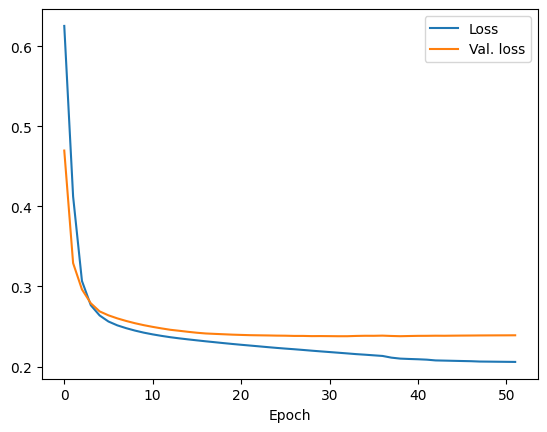

In [ ]:
plt.figure()
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# load testing file
feature_array_test, label_array_test, spec_array_test = get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root',
                                                                                  features, spectators, labels,
                                                                                  remove_mass_pt_window=True,
                                                                                  entry_stop=30000)

297/297 [==============================] - 0s 1ms/step


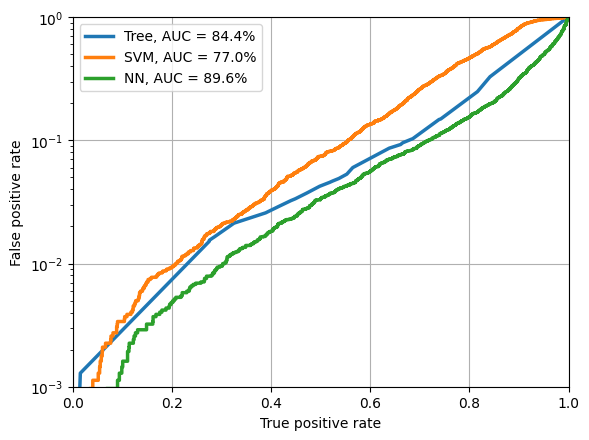

In [ ]:
# run model inference on test data set
predict_array_nn = keras_model.predict(feature_array_test)[:,1]
predict_array_tree = clf.predict_proba(feature_array_test)[:,1]
predict_array_svm = svm.decision_function(feature_array_test)

# create ROC curves
fpr_tree, tpr_tree, threshold_tree = roc_curve(label_array_test[:,1], predict_array_tree)
fpr_svm, tpr_svm, threshold_svm = roc_curve(label_array_test[:,1], predict_array_svm)
fpr_nn, tpr_nn, threshold_nn = roc_curve(label_array_test[:,1], predict_array_nn)

# plot ROC curves
plt.figure()
plt.plot(tpr_tree, fpr_tree, lw=2.5, label="Tree, AUC = {:.1f}%".format(auc(fpr_tree,tpr_tree)*100))
plt.plot(tpr_svm, fpr_svm, lw=2.5, label="SVM, AUC = {:.1f}%".format(auc(fpr_svm,tpr_svm)*100))
plt.plot(tpr_nn, fpr_nn, lw=2.5, label="NN, AUC = {:.1f}%".format(auc(fpr_nn,tpr_nn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001,1)
plt.xlim(0,1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

Try to add a boosted decision tree.

Exercise taken from [Javier Duarte's Particle Physics and Machine Learning class](https://github.com/jmduarte/capstone-particle-physics-domain).